In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
# from tqdm import tqdm
# import time
import pytorch_grad_cam
from pytorch_grad_cam import GradCAM
# from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
# from scipy.spatial.distance import cosine
# from torch.nn.functional import cosine_similarity
from pytorch_grad_cam.utils.image import show_cam_on_image


In [26]:
from resnet import ResNet, BasicBlock

In [27]:
batch_size = 1
# dataset has PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



Files already downloaded and verified
Files already downloaded and verified


In [28]:
# TODO
# ResNet(BasicBlock, [18, 18, 18])

In [29]:
# Define the ResNet model
class ResNet(nn.Module):
    def __init__(self, num_classes):
        super(ResNet, self).__init__()
        self.model = torchvision.models.resnet18()
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)

In [30]:
# Set the model to run on the GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
model = ResNet(num_classes=len(classes)).to(device)

# Load the model
model.load_state_dict(torch.load('./checkpoints/resnet_2step.pth'))

# model.load_state_dict(torch.load('./checkpoints/resnet110.pth'))

<All keys matched successfully>

In [31]:
# random_seed = 42
# torch.manual_seed(random_seed)
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

images.shape ->(batch_size, C, H, W)

In [32]:
# 从训练集中获取一些随机图像
dataiter = iter(train_loader)
images, labels = next(dataiter)

In [33]:
target_layers = [model.model.layer4[-1]]

# Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!
input_tensor = images  # -> torch.Size([1, 3, 32, 32])  B, C, H, W


In [47]:
print(target_layers)

[BasicBlock(
  (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)]


In [34]:
# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)

In [35]:
targets = [ClassifierOutputTarget(label) for label in labels]
# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

In [46]:
print(targets)

In [36]:
grayscale_cam.shape

(1, 32, 32)

images_np.shape = (4, 3, 32, 32)

In [37]:
# # 将 PyTorch 张量转换为 NumPy 数组
images_np = images.detach().cpu().numpy()

images_np.shape = (4, 32, 32, 3)

In [38]:
# 调整 images_np 的形状
images_np = np.transpose(images_np, (0, 2, 3, 1))

grayscale_cam.shape = (32, 32)

In [39]:
# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]

In [40]:
grayscale_cam.shape

(32, 32)

In [41]:
visualization = show_cam_on_image(images_np, grayscale_cam, use_rgb=True)

In [42]:
# 定义显示图像的函数
def imshow(img):
    img = img / 2 + 0.5     # 反标准化
    npimg = img.numpy() # -> (C, H, W) 
    # print(npimg.shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # -> (H, W, C) 
    plt.axis('off')
    plt.imsave('./img/ori_image.png',np.transpose(npimg, (1, 2, 0)))
    plt.show()

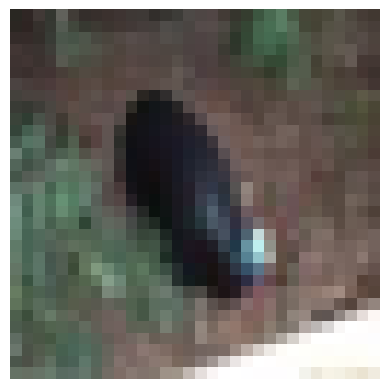

In [43]:
imshow(torchvision.utils.make_grid(images))

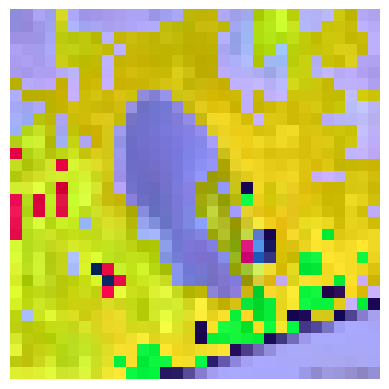

In [44]:
plt.imshow(visualization[0])
plt.axis('off')
plt.imsave("./img/test.png",visualization[0])

batch_size ！= 1 的时候使用这个

In [45]:
# visualizations = []
# fig, axes = plt.subplots(1, batch_size)
# for i in range(batch_size):
#     ax = axes[i]
#     ax.imshow(visualization[i])
#     ax.axis('off')
#     visualizations.append((visualization[i]))
    

# ## 调整子图之间的间距
# ## plt.tight_layout()

# for i, vis in enumerate(visualizations):
#     # plt.imshow(vis)
#     plt.imsave(f'./img/test_{i}.png', vis)
